In [1]:

import tganalysis
import os
import emoji
import pandas as pd
from factor_analyzer import FactorAnalyzer

paths = ['C:/Users/mk/Downloads/Telegram Desktop/ChatExport_2023-12-30_']

filename = os.path.join('data', paths[0], 'result.json')


In [2]:

from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)
emb = NewsEmbedding()
segmenter = Segmenter()
morph_vocab = MorphVocab()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)


In [3]:
tg = tganalysis.tg_json_analysis(filename)
data = tg.df
data

{521643: msg(id=521643, type='message', date='2023-10-01T00:09:46', from_name='Ксения Щербак', from_id='user239502090', reply_to_message_id=521634, text='У меня раньше было такое, что я не могла каждый раз его юзать, был перепрот( все разваливалось и прямилось). А сейчас у меня всегда ливином либо он, либо шелк dnc и все супер) видимо раньше были волосы недостаточно увлажнены', words=None, year=2023, month=10, day=1, week=39, weekday=7, hour=0, td_idf=None),
 521644: msg(id=521644, type='message', date='2023-10-01T00:12:31', from_name='Ксения Щербак', from_id='user239502090', reply_to_message_id=521636, text='Я задумалась о смене состава после ваших слов о трех видах протеина) потому что я не вижу там их в таком количестве \nИ в карте товара состав отличается от того, что на баночке моей', words=None, year=2023, month=10, day=1, week=39, weekday=7, hour=0, td_idf=None),
 521645: msg(id=521645, type='message', date='2023-10-01T00:15:01', from_name='Mariya Gudova', from_id='user349508138

In [8]:
# data[522845].text
# text = data[522835].text


docs = list()

for dp in data:
    text = data[dp].text
    text = emoji.replace_emoji(text, lambda a,_:f".{a}. ")
    text = text.replace(') ', "). ")
    text = text.replace('\n', "\n. ")
    text = '. '.join([a.capitalize() for a in text.split('. ')])
    try:
        doc = Doc(text)
        doc.segment(segmenter)
        doc.tag_morph(morph_tagger)
        doc.parse_syntax(syntax_parser)
        for token in doc.tokens:
            token.lemmatize(morph_vocab)
        docs.append({'id': dp, 'from_name': data[dp].from_id, 'doc': doc})
    except:
        pass
    




In [9]:
# text = 'Мне алоэ плоховато распутывает и не очень делал волосы скользкими, хотя обычно у меня такой проблемы нет, в итоге получался очень большой расход'
# text = emoji.replace_emoji(text, lambda a,_:f".{a}. ")
# text = text.replace(') ', "). ")
# text = text.replace('\n', "\n. ")
# text = '. '.join([a.capitalize() for a in text.split('. ')])
# doc = Doc(text)
# doc.segment(segmenter)
# doc.tag_morph(morph_tagger)
# doc.parse_syntax(syntax_parser)
# for token in doc.tokens:
#     token.lemmatize(morph_vocab)
# doc.tokens

In [10]:
roots_all = []
for doc_index, doc in enumerate(docs):
    for sent_index, sent in enumerate(doc['doc'].sents):
        roots = dict()
        for token in sent.tokens:
            if (token.rel == 'root') and (token.pos == 'VERB'):
                if not token.id in roots:
                    roots[token.id] = {'doc_index': doc_index, 'sent_index': sent_index}
                roots[token.id]['root'] = token
            if token.rel == 'obj':
                try:
                    root_token = sent.tokens[int(token.head_id[2:])-1]
                except:
                    root_token = sent.tokens[int(token.head_id[3:])-1]
                if not (root_token.rel == 'root' and root_token.pos == 'VERB'):
                    continue
                if not token.head_id in roots:
                    roots[token.head_id] = {'doc_index': doc_index, 'sent_index': sent_index}
                roots[token.head_id]['obj'] = token
            if token.rel == 'nsubj':
                try:
                    root_token = sent.tokens[int(token.head_id[2:])-1]
                except:
                    root_token = sent.tokens[int(token.head_id[3:])-1]
                if not (root_token.rel == 'root' and root_token.pos == 'VERB'):
                    continue
                if not token.head_id in roots:
                    roots[token.head_id] = {'doc_index': doc_index, 'sent_index': sent_index}
                roots[token.head_id]['nsubj'] = token
            if token.rel == 'advmod':
                try:
                    root_token = sent.tokens[int(token.head_id[2:])-1]
                except:
                    root_token = sent.tokens[int(token.head_id[3:])-1]
                if not (root_token.rel == 'root' and root_token.pos == 'VERB'):
                    continue
                if not token.head_id in roots:
                    roots[token.head_id] = {'doc_index': doc_index, 'sent_index': sent_index}
                roots[token.head_id]['advmod'] = token
        if roots:
            roots_all.append(roots)                
        # print(roots)
        # break


In [1300]:
df = list()
for roots in roots_all:
    for root_id, root in roots.items():
        from_name = docs[root['doc_index']]['from_name']
        msg_id = docs[root['doc_index']]['id']
        d = {'from_name': from_name, 'msg_id': msg_id}
        try:
            d['advmod'] = root['advmod'].lemma
        except:
            pass
        try:
            d['root'] = root['root'].lemma
        except:
            pass
        try:
            d['nsubj'] = root['nsubj'].lemma
        except:
            pass
        try:
            d['obj'] = root['obj'].lemma
        except:
            pass
        df.append(d)
    # break
# doc[roots]

df = pd.DataFrame(df)
df_orig = df.copy()

# df


In [1301]:
names = df[['from_name', 'msg_id']].groupby('from_name').count()['msg_id']
names = names[names > 10]
names

from_name
channel1562686954     14
user1016602713        50
user1023866472        51
user1032092618        34
user1035089837        46
                    ... 
user967826430         16
user969898390         19
user990928            58
user995426526         28
user99691506         133
Name: msg_id, Length: 299, dtype: int64

In [1302]:
df = df.fillna('').groupby(['from_name', 'nsubj', 'advmod', 'root', 'obj']).count().reset_index().set_index('from_name')
# df

In [1303]:
df = df[df.index.isin(names.index)]
df.loc[:,'msg_id'] = df['msg_id']/names
df.sort_values('msg_id', ascending=False).head(30)

C:\Users\mk\AppData\Local\Temp\ipykernel_13148\3309883794.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.07142857 0.07142857 0.07142857 ... 0.0075188  0.0075188  0.0075188 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:,'msg_id'] = df['msg_id']/names


,nsubj,advmod,root,obj,msg_id
from_name,,,,,
user946901563,,,мочь,,0.200000
user649911954,,,благодарить,,0.200000
user349161498,,,казаться,,0.200000
user145561673,,,мочь,,0.181818
user870051977,я,,пробовать,,0.142857
user398257425,я,,думать,,0.133333
user924261106,,не,мочь,,0.125000
user711590276,,,понимать,,0.125000
user5289274627,,,покупать,,0.117647


In [1319]:
param = 'obj'

nsubjs = df[[param, 'msg_id']].groupby(param).count().query('msg_id < 1000 & msg_id > 10').sort_values('msg_id', ascending=False)
# .query('msg_id < 400 & msg_id > 3')
nsubjs

,msg_id
obj,
он,404
волос,363
гель,219
я,218
это,188
...,...
прям,11
пудра,11
кудряшка,11


In [1320]:
df = df[df[param].isin(nsubjs.index)]
df

,nsubj,advmod,root,obj,msg_id
from_name,,,,,
user1016602713,бот,,одобрить,он,0.040000
user1023866472,,,заказать,шампунь,0.019608
user1023866472,,,купить,фен,0.019608
user1023866472,,еще,попросить,скидка,0.019608
user1023866472,,не,смывать,кондиционер,0.019608
...,...,...,...,...,...
user99691506,это,,рекомендовать,гель,0.007519
user99691506,я,,нанести,ложка,0.007519
user99691506,я,,получать,такой,0.007519


In [1321]:
users_corr = df.pivot_table(index=param, columns='from_name', values='msg_id', aggfunc='sum').fillna(0).corr()
# users_corr = users_corr > 0
# users_corr = users_corr.corr()
users_corr# = users_corr[users_corr.index]

from_name,user1016602713,user1023866472,user1032092618,user1035089837,user1058655244,user1076210374,user1086978549,user1100099375,user1102922011,user1108274242,...,user946901563,user946990194,user953867292,user95574509,user956384450,user967826430,user969898390,user990928,user995426526,user99691506
from_name,,,,,,,,,,,,,,,,,,,,,
user1016602713,1.000000,0.441552,-0.012699,-0.020477,0.213836,-0.010963,-0.014244,-0.010963,-0.006289,0.576272,...,-0.010963,0.272232,-0.006289,0.631336,-0.010963,-0.008923,-0.006289,-0.014244,-0.008459,0.153964
user1023866472,0.441552,1.000000,-0.028760,-0.046374,0.028487,-0.024827,-0.032258,-0.024827,-0.014244,0.362061,...,-0.024827,0.227510,-0.014244,0.256632,-0.024827,-0.020207,-0.014244,0.174194,-0.019158,0.098882
user1032092618,-0.012699,-0.028760,1.000000,0.124035,0.114291,-0.022135,0.201319,-0.022135,-0.012699,-0.037535,...,-0.022135,0.116128,-0.012699,-0.032686,-0.022135,-0.018016,-0.012699,-0.028760,-0.017081,0.125278
user1035089837,-0.020477,-0.046374,0.124035,1.000000,0.081906,-0.035692,0.102023,-0.035692,0.307148,-0.060523,...,0.154663,0.327066,-0.020477,-0.052705,-0.035692,-0.029050,-0.020477,-0.046374,-0.027541,0.082298
user1058655244,0.213836,0.028487,0.114291,0.081906,1.000000,-0.065775,0.085462,0.153476,-0.037736,0.223073,...,0.080392,0.245392,0.088050,0.186163,0.153476,-0.053535,-0.037736,0.085462,0.400407,0.188434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
user967826430,-0.008923,-0.020207,-0.018016,-0.029050,-0.053535,-0.015552,-0.020207,-0.015552,-0.008923,-0.026372,...,-0.015552,-0.048956,-0.008923,-0.022966,-0.015552,1.000000,-0.008923,-0.020207,-0.012001,-0.042381
user969898390,-0.006289,-0.014244,-0.012699,-0.020477,-0.037736,-0.010963,-0.014244,-0.010963,-0.006289,-0.018589,...,-0.010963,-0.034508,-0.006289,-0.016188,-0.010963,-0.008923,1.000000,-0.014244,-0.008459,-0.029874
user990928,-0.014244,0.174194,-0.028760,-0.046374,0.085462,-0.024827,-0.032258,-0.024827,-0.014244,0.227341,...,-0.024827,0.060785,-0.014244,-0.036662,-0.024827,-0.020207,-0.014244,1.000000,0.185195,-0.067656


<Axes: xlabel='from_name', ylabel='from_name'>

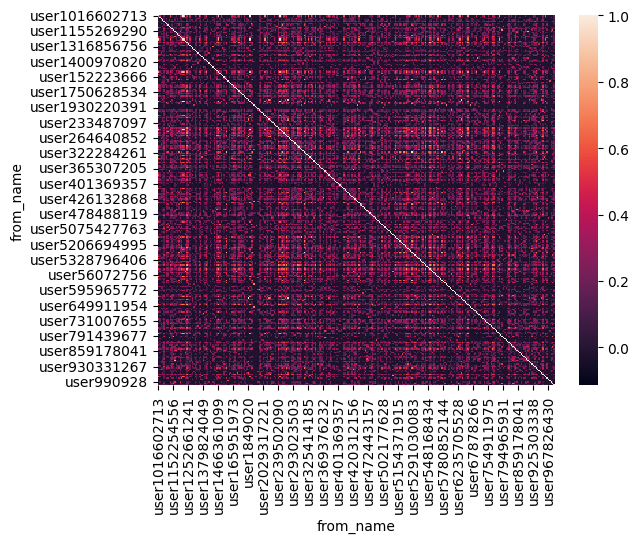

In [1322]:
import matplotlib.pyplot as plt

import seaborn as sns
plt.figure()
c= users_corr
sns.heatmap(c)

2.909353126961463 <0: 56


variable
user1466361099    0.142487
user553317239     0.136691
user643378201     0.136434
user123346199     0.130980
user545849645     0.129287
                    ...   
user502177628    -0.008800
user784660635    -0.009780
user1371108950   -0.010127
user314927254    -0.010549
user379191211    -0.013094
Name: PC1, Length: 291, dtype: float64

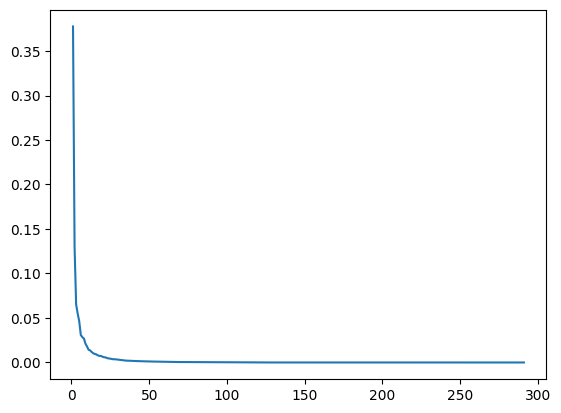

In [1323]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_out = PCA().fit(users_corr)

ev = pca_out.explained_variance_ratio_
plt.plot(range(1,users_corr.shape[1]+1),ev)

loadings = pca_out.components_
num_pc = len(users_corr)
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = users_corr.columns.values
loadings_df = loadings_df.set_index('variable').sort_values('PC1', ascending=False)
# loadings_df['PC1'].to_list()
print(ev[0]/ev[1], '<0:', sum(loadings_df.loc[:,'PC1'] < 0))
loadings_df.loc[:,'PC1']



In [1324]:
users_corr.loc[loadings_df.index.values[0], loadings_df.index.values[1]]

0.7640143588241372

In [1325]:
df.loc[loadings_df.index.values[-1], ['msg_id', param]].groupby(param).sum().sort_values('msg_id', ascending=False).head(30)

,msg_id
obj,
весь,0.02
вопрос,0.02
вы,0.02
день,0.02
кудри,0.02
лубрикант,0.02
средство,0.02


In [1326]:
from collections import Counter
words = Counter()
for i in range(100):
    try:
        a = df_orig.set_index('from_name').loc[loadings_df.index.values[i], ['msg_id', param]].groupby(param).sum().sort_values('msg_id', ascending=False).index.to_list()
        # a = df.loc[loadings_df.index.values[i], ['msg_id', param]].groupby(param).sum().sort_values('msg_id', ascending=False).index.to_list()
    except:
        pass
    words.update(a)

# [k for k, w in words.items() if w > 7]
pd.Series(words).sort_values(ascending=False).head(25)


он           82
волос        78
гель         59
это          49
что          49
они          46
я            45
ничто        41
она          39
шампунь      37
весь         35
отзыв        35
укладка      34
средство     33
что-то       33
состав       30
каста        30
себя         29
тот          28
эффект       28
пара         27
вода         26
объем        26
результат    25
пенка        25
dtype: int64

In [1327]:
# df.groupby(['nsubj', 'advmod', 'root','obj']).agg(['mean', 'count']).sort_values(('msg_id', 'mean'), ascending=False).to_clipboard(decimal=',')

In [1328]:
df[['msg_id', 'root', 'obj', 'nsubj', 'advmod']].groupby(['nsubj','advmod', 'root', 'obj',  ]).count().reset_index().sort_values('msg_id', ascending=False)
#.to_clipboard()
# .head(30)

,nsubj,advmod,root,obj,msg_id
258,,,ждать,отзыв,19
840,,,попробовать,он,11
461,,,любить,он,10
830,,,попробовать,гель,9
978,,,просить,прощение,8
...,...,...,...,...,...
2051,,обязательный,выбирать,банк,1
2050,,обязательно,расчесывать,волос,1
2049,,обязательно,попробовать,соло,1
2048,,обязательно,обновить,стайлинг,1


In [1329]:
texts = pd.DataFrame(data).transpose()[[3, 4, 0, 6]].rename(columns={3:'from_name', 4:'from_id', 0: 'msg_id', 6:'text'}).set_index('msg_id')


In [1336]:
df_orig.query('nsubj == "водоросль" & root == "получаться"')
df_orig.query('nsubj == "диффузор" & root == "мочь"')
df_orig.query('nsubj == "банк"').groupby('root').count().sort_values('msg_id', ascending=False)

,from_name,msg_id,advmod,nsubj,obj
root,,,,,
быть,10,10,4,10,0
существовать,4,4,4,4,0
стоить,3,3,0,3,0
делать,3,3,3,3,1
мочь,3,3,2,3,0
подойти,2,2,1,2,0
подходить,2,2,2,2,0
попадаться,2,2,2,2,0
кгм,2,2,1,2,0


In [1339]:
msg_ids = df_orig.query('nsubj == "банк"  & root == "быть"')['msg_id']
msg_ids

5978     527934
11836    533768
14353    536358
15211    537282
21891    544644
22152    544895
24380    547342
28388    551615
29837    553081
40258    567396
Name: msg_id, dtype: int64

In [1340]:
texts[texts.index.isin(msg_ids)]['text'].to_clipboard()

In [1333]:
verb = 'мочь'
df.pivot_table(index='from_name', columns='root', values='msg_id', aggfunc='count')[[verb]].dropna().sort_values(verb, ascending=False)

root,мочь
from_name,
user303829083,4.0
user553317239,4.0
user479213201,4.0
user239502090,4.0
user123346199,3.0
user923493184,2.0
user504029372,2.0
user152223666,2.0
user349508138,2.0
